In [2]:
include("optim_lib.jl")
include("lib_func.jl")

# Constants and Parameters
d1, d2, ds = 6, 6, 1  # Degree range and step
const n, a, b = 2, 5, 1 
const C = a / b  # Scaling constant, C is appears in `main_computation`, maybe it should be a parameter.
const delta, alph = .5 , 9 / 10  # Sampling parameters
f = camel # Objective function

camel (generic function with 1 method)

In [3]:
coeffs_poly_approx = main_gen(f, n, d1, d2, ds, delta, alph, C, 0.1)
coeffs_poly_precis = precise_gen(f, n, d1, d2, ds, delta, alph, C, 0.1)

dimension Vector space: 28
sample size: 196
dimension Vector space: 36
sample size: 289
dimension Vector space: 45
sample size: 400
dimension Vector space: 28
sample size: 196
dimension Vector space: 36
sample size: 289
dimension Vector space: 45
sample size: 400


3-element Vector{Vector{BigFloat}}:
 [2072.916666666666110629930147504375831617360456432270874715670330649802984079463, 1.576488600104967708868992522998180325724493745122958672616346174009124517450459e-13, 1835.156249999999388915710624223797234578456465953714480053885035812609269470176, 1.787538921061919969384317283672472941457728383966358624343535679461774365269811e-14, 812.499999999999672489151276100601989962097491243619268502499227822689733336043, -2.036359495862301238384238513112276396111910968821632346281182810962210536877646e-13, 162.7604166666663838832961550550679614696192513879870884462172958012977218238894, 5.10351995847963298009041386249367799908409279901956679443383649854342220363928e-14, 25.00000000000001128677649344013447824857247043344233426369212227956794324260253, 1.303524028143209541408424444654596576567432200679867194478108909761449139609165e-14  …  1.511415022811131557658166971990632788506351528681916032889860842191848315255056e-14, 2.59568329768297200228143861496353

In [4]:
using DynamicPolynomials, MultivariatePolynomials, HomotopyContinuation, ProgressLogging, DataFrames

include("hom_solve.jl") # Include the homotopy solver and main function
vars = @polyvar(x[1:n]) # Define polynomial ring 
h_x, h_y, col = main_2d(n, d1, d2, ds, coeffs_poly_approx) # main_2d is in hom_solve.jl
df = DataFrame(x=C * h_x, y=C * h_y, col=col)
df[!, :result] = [f([df.x[i], df.y[i]]) for i in 1:nrow(df)];
df[!, :local_minima] = zeros(nrow(df))
df[!, :distance_to_minima] = zeros(nrow(df))
df[!, :steps] = zeros(Int, nrow(df))
df[!, :converged] = falses(nrow(df))

# println(df)


Computing mixed cells... 2    Time: 0:00:00
Computing mixed cells... 5    Time: 0:00:01
  mixed_volume:  25


Tracking 25 paths...   8%|██▍                           |  ETA: 0:01:46



Tracking 25 paths... 100%|██████████████████████████████| Time: 0:00:10
  # paths tracked:                  25
  # non-singular solutions (real):  25 (15)
  # singular endpoints (real):      0 (0)
  # total solutions (real):         25 (15)
Degree: 6
Number of solutions: 15
Tracking 36 paths...   6%|█▋                            |  ETA: 0:01:07



Tracking 36 paths... 100%|██████████████████████████████| Time: 0:00:03
  # paths tracked:                  36
  # non-singular solutions (real):  36 (18)
  # singular endpoints (real):      0 (0)
  # total solutions (real):         36 (18)
Degree: 7
Number of solutions: 15
Tracking 49 paths...   4%|█▎                            |  ETA: 0:01:34



Tracking 49 paths... 100%|██████████████████████████████| Time: 0:00:04
  # paths tracked:                  49
  # non-singular solutions (real):  49 (19)
  # singular endpoints (real):      0 (0)
  # total solutions (real): 

45-element BitVector:
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 ⋮
 0
 0
 0
 0
 0
 0
 0
 0
 0

Plot all the critical points on the contour plot of the objective, colored by degree.

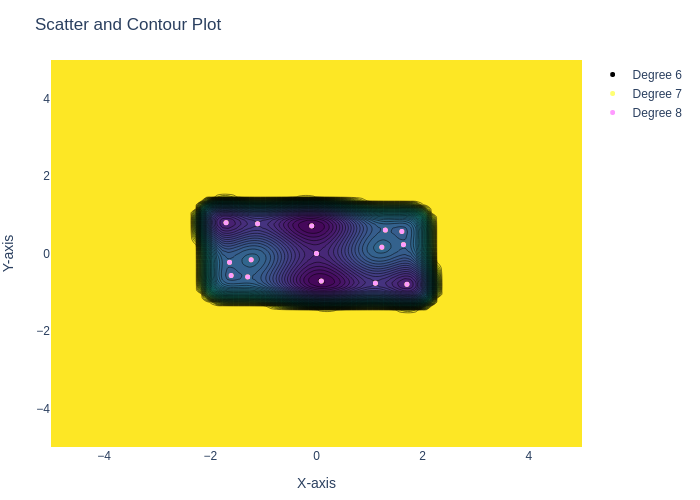

In [12]:
using PlotlyJS, Colors

# Generate the grid and evaluate the function
N = 100  # resolution of the grid
x = range(-C, C, length=N)
y = range(-C, C, length=N)
z = [f([xi, yi]) for yi in y, xi in x]
# Generate a color palette based on the number of unique `col` values
unique_cols = unique(df.col)
num_colors = length(unique_cols)
color_palette = distinguishable_colors(num_colors)
# Map the `col` values to the corresponding colors
col_to_color = Dict(unique_cols .=> color_palette)
# Create individual scatter traces for each unique `col` value
scatter_traces = [scatter(x=df[df.col .== c, :x], y=df[df.col .== c, :y], mode="markers", marker=attr(color=col_to_color[c], size=5), name="Degree $c") for c in unique_cols]

# Define custom contour levels focusing on 0 < z < 10
clip_value = 10.0
z_clipped = map(x -> min(x, clip_value), z)  # clip values at 10
min_z_clipped = minimum(z_clipped)
max_z_clipped = maximum(z_clipped)

# Define custom contour levels for 0 < z < 10 and group values > 10
levels = exp10.(range(log10(max(min_z_clipped, 1e-10)), log10(clip_value), length=80))


# Create the contour plot with custom levels
cp = contour(x=x, y=y, z=z_clipped,  levels=levels, ncontours=length(levels),
             colorscale="Viridis", showscale=false)

# Combine contour plot and scatter traces
all_traces = [cp; scatter_traces...]
# Customize layout to handle legend groups
layout = Layout(
    title="Scatter and Contour Plot",
    xaxis_title="X-axis",
    yaxis_title="Y-axis",
    legend=(tracegroupgap=10, groupclick="toggleitem"),
    height=600 # Increase the height to make room for the legend
)
# Display the combined plot with legend
display(plot(all_traces, layout))

Doesn't make too much sense, but maybe we could plot the level sets of the polynomial approximants

Initialize Zeroth order optimization method at each of the critical points of the approximants. 

In [6]:
using Optim
for i in 1:nrow(df)
    println("Optimizing for point $i")
    x0 = [df.x[i], df.y[i]]
    res = Optim.optimize(f, x0, LBFGS(), Optim.Options(show_trace=true))
    minimizer = Optim.minimizer(res)
    min_value = Optim.minimum(res)
    steps = res.iterations
    converged = Optim.converged(res)

    distance = norm(x0 - minimizer)

    df.local_minima[i] = min_value
    df.distance_to_minima[i] = distance
    df.steps[i] = steps
    df.converged[i] = converged

    println("Initial point: ", x0)
    println("Minimizer: ", minimizer)
    println("Distance to minima: ", distance)
    println("Number of steps: ", steps)
    println("Converged: ", converged)
    println(summary(res))
end


Optimizing for point 1
Iter     Function value   Gradient norm 
     0     5.437186e-01     4.308552e-10
 * time: 0.01858997344970703
Initial point: [1.109205336805113, -0.7682680925094827]
Minimizer: [1.109205336805113, -0.7682680925094827]
Distance to minima: 0.0
Number of steps: 0
Converged: true
L-BFGS
Optimizing for point 2
Iter     Function value   Gradient norm 
     0    -2.154638e-01     1.894117e-09
 * time: 1.4066696166992188e-5
Initial point: [1.7036067149697944, -0.7960835686725494]
Minimizer: [1.7036067149697944, -0.7960835686725494]
Distance to minima: 0.0
Number of steps: 0
Converged: true
L-BFGS
Optimizing for point 3
Iter     Function value   Gradient norm 
     0     2.104250e+00     1.368991e-09
 * time: 5.9604644775390625e-6
Initial point: [-1.6071047529198699, -0.5686514548840216]
Minimizer: [-1.6071047529198699, -0.5686514548840216]
Distance to minima: 0.0
Number of steps: 0
Converged: true
L-BFGS
Optimizing for point 4
Iter     Function value   Gradient norm 
  

In [14]:
using CSV
filtered_df = df[df.col.==6, :]
CSV.write("data/camel_3_d$d1.csv", filtered_df)


"data/camel_d6.csv"

In [9]:
# plot on subdomain 
SmC = 0.5 * C
x = range(-1 / 15, 1 / 15, length=N)
y = range(-5, 5, length=N)
# Generate the grid and evaluate the function
zi = [f([xi, yi]) for yi in y, xi in x]
# Create the plot
sf = surface(x=x, y=y, z=zi)
# Layout for the plot
layout = Layout(title="3D Plot of f(x, y) = sin(πx) * sin(πy)",
    scene=attr(
        xaxis_title="x",
        yaxis_title="y",
        zaxis_title="f(x, y)"
    ))
# Display the plot
# plot(sf, layout)

layout with fields margin, scene, template, and title
